In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyspark
!pip install catboost
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=9d4cdfe6991cb985b7625e6995f428fa72fd0473e31e0e17bb6cafa696db1101
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.9 MB/s eta 0:00:00


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, countDistinct, mean, sum, percentile_approx, min, max, count
from pyspark.sql.window import Window
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
# Initialize Spark session
spark = SparkSession.builder.appName("HealthcareAnalysis").getOrCreate()

In [5]:
# Load data
health_data = spark.read.csv('/content/drive/MyDrive/big data/Final dataset/train_data.csv', header=True, inferSchema=True)

In [6]:
# Display schema and some basic information
health_data.printSchema()

root
 |-- case_id: integer (nullable = true)
 |-- Hospital_code: integer (nullable = true)
 |-- Hospital_type_code: string (nullable = true)
 |-- City_Code_Hospital: integer (nullable = true)
 |-- Hospital_region_code: string (nullable = true)
 |-- Available Extra Rooms in Hospital: integer (nullable = true)
 |-- Department: string (nullable = true)
 |-- Ward_Type: string (nullable = true)
 |-- Ward_Facility_Code: string (nullable = true)
 |-- Bed Grade: integer (nullable = true)
 |-- patientid: integer (nullable = true)
 |-- City_Code_Patient: integer (nullable = true)
 |-- Type of Admission: string (nullable = true)
 |-- Severity of Illness: string (nullable = true)
 |-- Visitors with Patient: integer (nullable = true)
 |-- Age: string (nullable = true)
 |-- Admission_Deposit: integer (nullable = true)
 |-- Stay: string (nullable = true)



In [7]:
health_data.show(5)

+-------+-------------+------------------+------------------+--------------------+---------------------------------+------------+---------+------------------+---------+---------+-----------------+-----------------+-------------------+---------------------+-----+-----------------+-----+
|case_id|Hospital_code|Hospital_type_code|City_Code_Hospital|Hospital_region_code|Available Extra Rooms in Hospital|  Department|Ward_Type|Ward_Facility_Code|Bed Grade|patientid|City_Code_Patient|Type of Admission|Severity of Illness|Visitors with Patient|  Age|Admission_Deposit| Stay|
+-------+-------------+------------------+------------------+--------------------+---------------------------------+------------+---------+------------------+---------+---------+-----------------+-----------------+-------------------+---------------------+-----+-----------------+-----+
|      1|            8|                 c|                 3|                   Z|                                3|radiotherapy|        R|

In [8]:
health_data.describe().show()
print(f"Data count: {health_data.count()}")

+-------+---------------+------------------+------------------+------------------+--------------------+---------------------------------+------------------+---------+------------------+------------------+------------------+-----------------+-----------------+-------------------+---------------------+------+-----------------+------------------+
|summary|        case_id|     Hospital_code|Hospital_type_code|City_Code_Hospital|Hospital_region_code|Available Extra Rooms in Hospital|        Department|Ward_Type|Ward_Facility_Code|         Bed Grade|         patientid|City_Code_Patient|Type of Admission|Severity of Illness|Visitors with Patient|   Age|Admission_Deposit|              Stay|
+-------+---------------+------------------+------------------+------------------+--------------------+---------------------------------+------------------+---------+------------------+------------------+------------------+-----------------+-----------------+-------------------+---------------------+------+

In [9]:
# Encode categorical columns
indexers = ['Department', 'Hospital_type_code', 'Hospital_region_code', 'Ward_Type', 'Ward_Facility_Code', 'Type of Admission', 'Severity of Illness', 'Age', 'Stay']
for column in indexers:
    indexer = StringIndexer(inputCol=column, outputCol=column + "_index")
    health_data = indexer.fit(health_data).transform(health_data).drop(column).withColumnRenamed(column + "_index", column)

In [10]:
# Splitting hospitals depending on their codes
HC_dict = health_data.groupBy("Hospital_code").count().orderBy("Hospital_code").rdd.collectAsMap()

In [11]:
# Convert to pandas for visualization purposes
health_data_pd = health_data.toPandas()

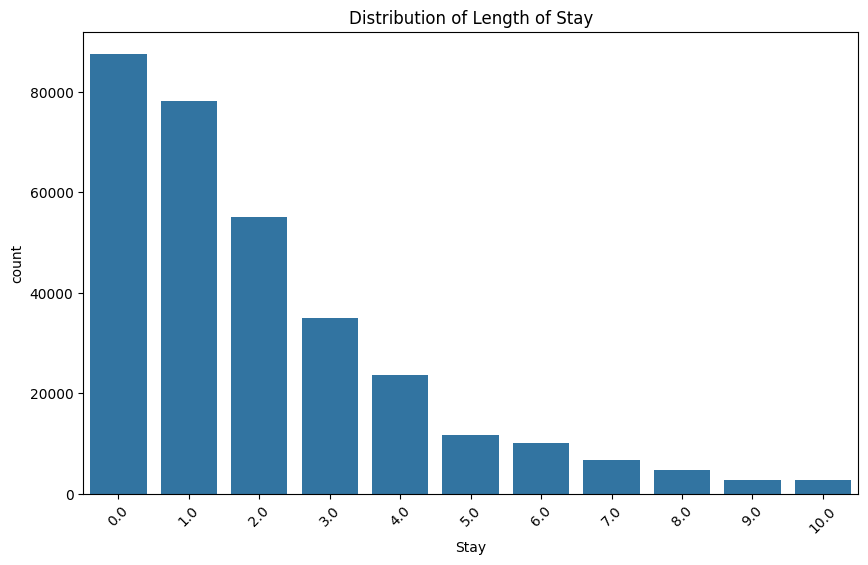

In [12]:
# Target variable distribution with custom figure size
plt.figure(figsize=(10, 6))
sns.countplot(x='Stay', data=health_data_pd)
plt.title('Distribution of Length of Stay')
plt.xticks(rotation=45)
plt.show()

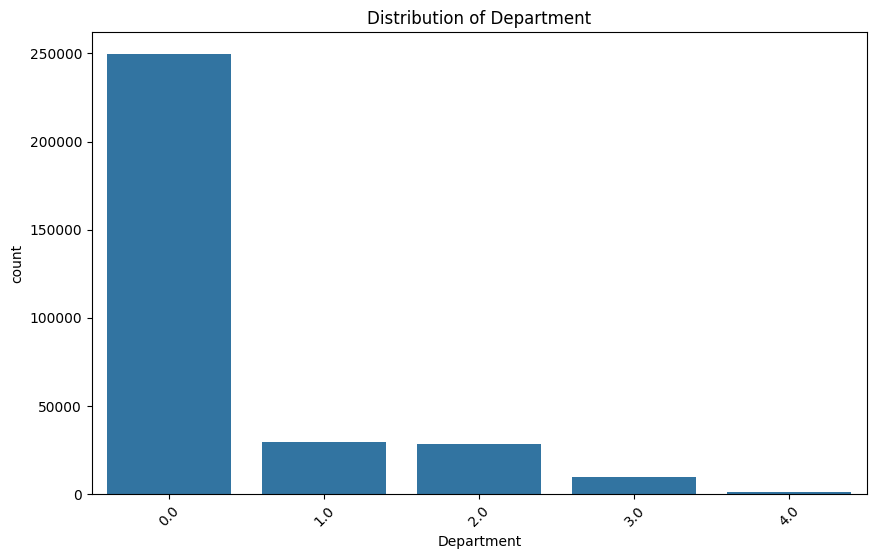

In [13]:
# Example for exploring 'Department' with custom figure size
plt.figure(figsize=(10, 6))
sns.countplot(x='Department', data=health_data_pd)
plt.title('Distribution of Department')
plt.xticks(rotation=45)
plt.show()

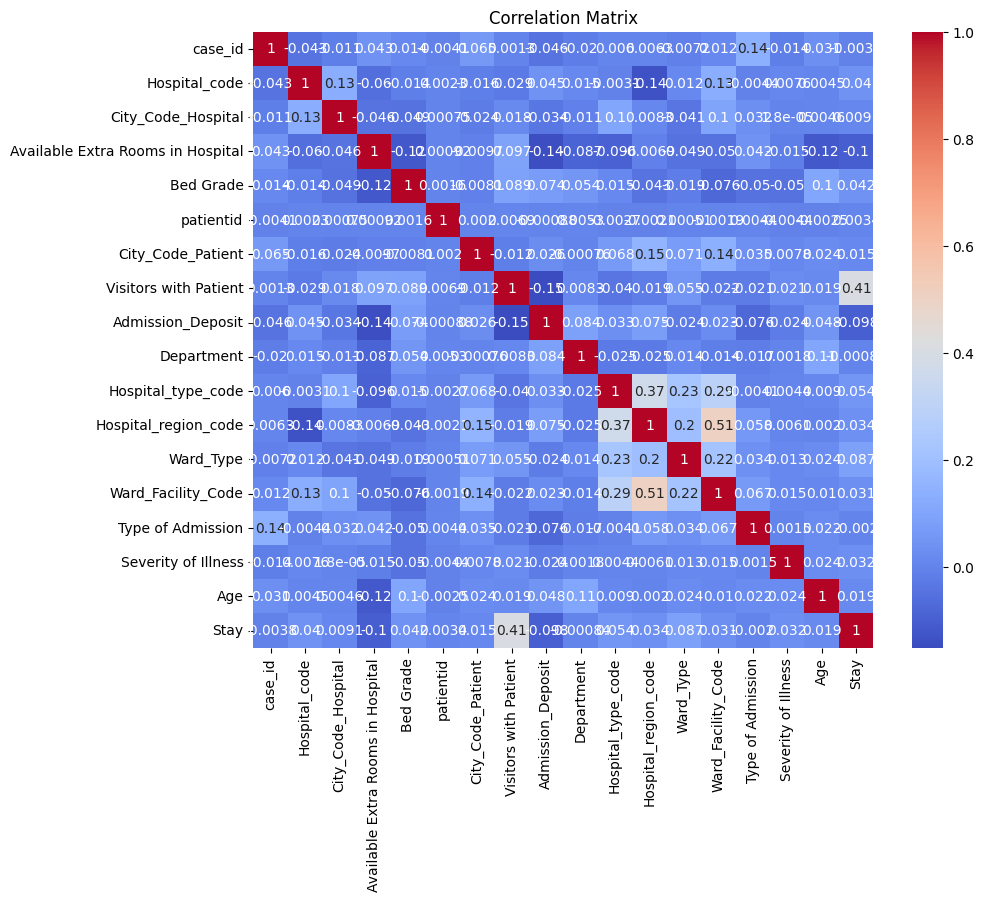

In [14]:
# Example for exploring correlation with numerical features with custom figure size
plt.figure(figsize=(10, 8))
correlation_matrix = health_data_pd.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

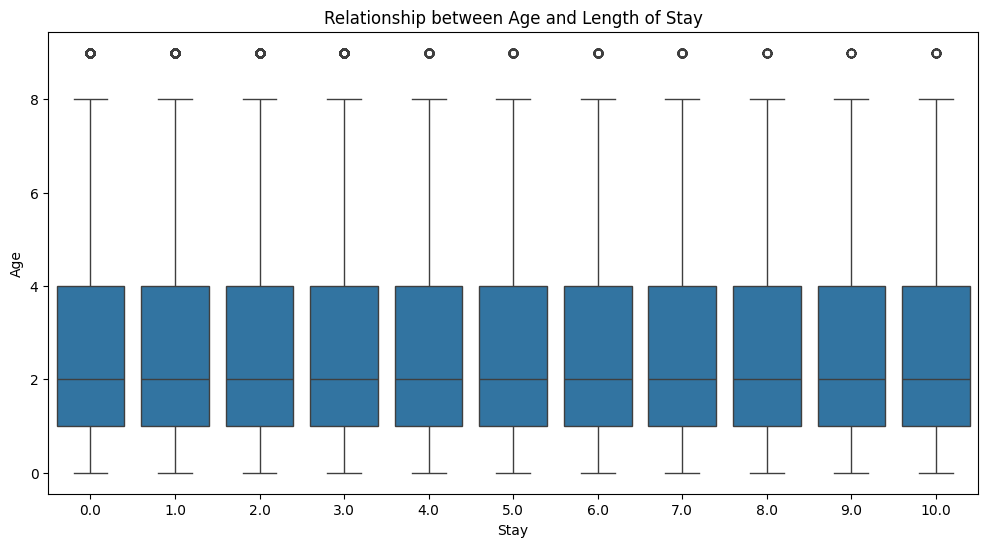

In [15]:
# Example for exploring the relationship between 'Age' and 'Stay' with custom figure size
plt.figure(figsize=(12, 6))
sns.boxplot(x='Stay', y='Age', data=health_data_pd)
plt.title('Relationship between Age and Length of Stay')
plt.show()

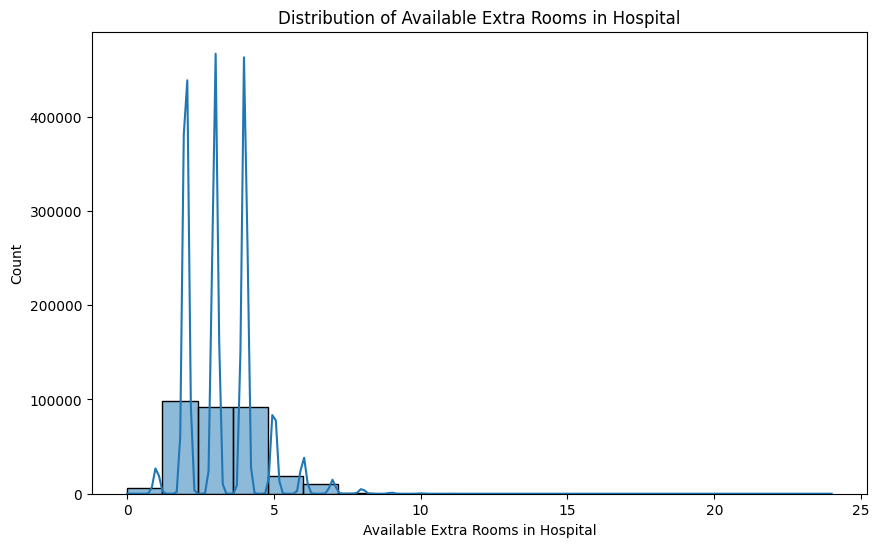

In [16]:
# Example for visualizing the distribution of 'Available Extra Rooms in Hospital' with custom figure size
plt.figure(figsize=(10, 6))
sns.histplot(health_data_pd['Available Extra Rooms in Hospital'], bins=20, kde=True)
plt.title('Distribution of Available Extra Rooms in Hospital')
plt.show()

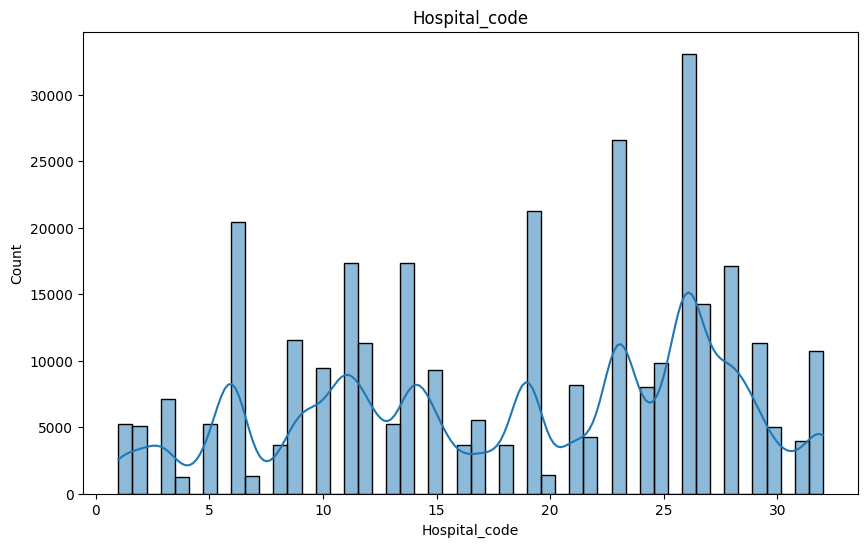

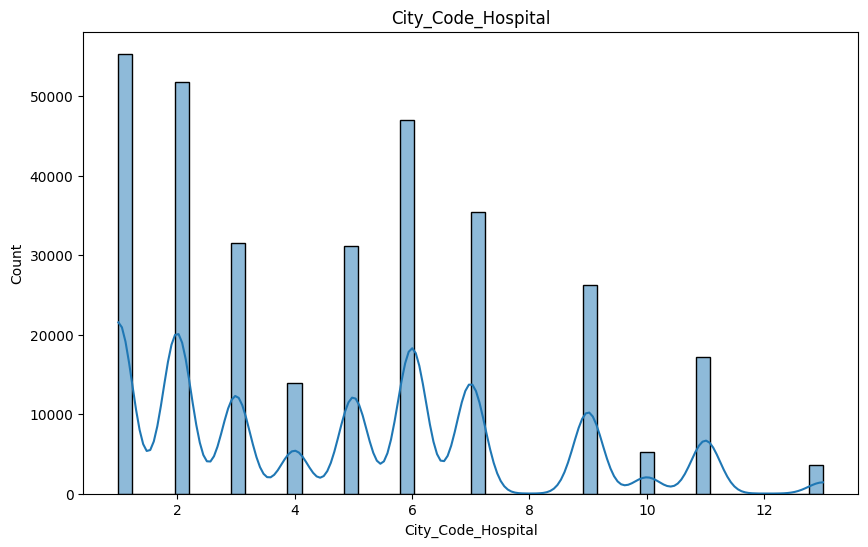

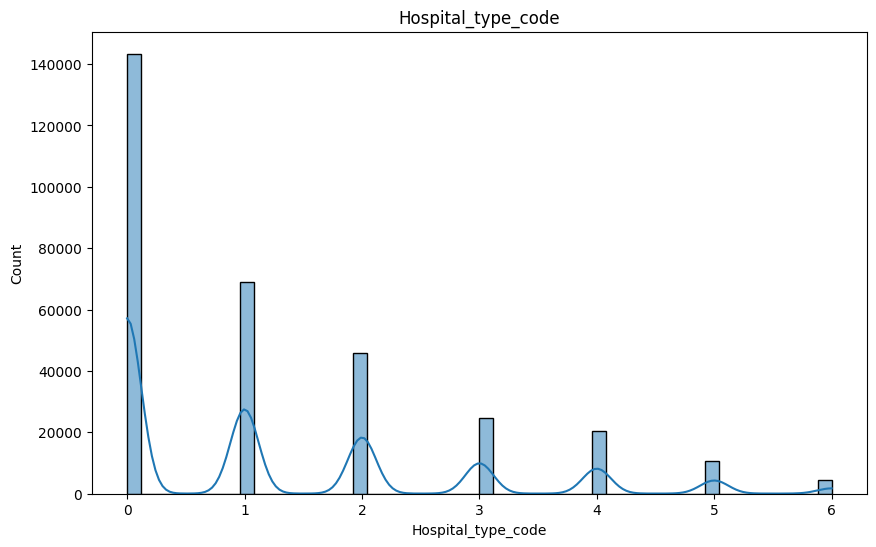

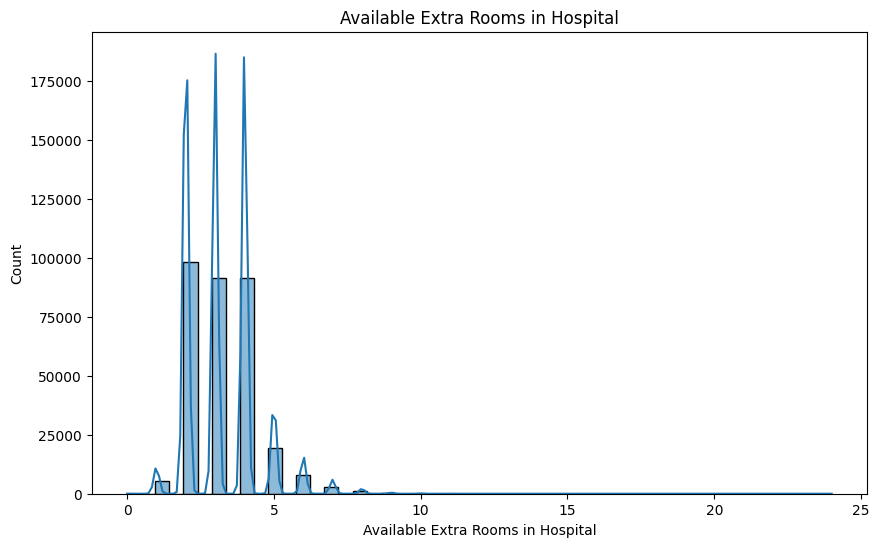

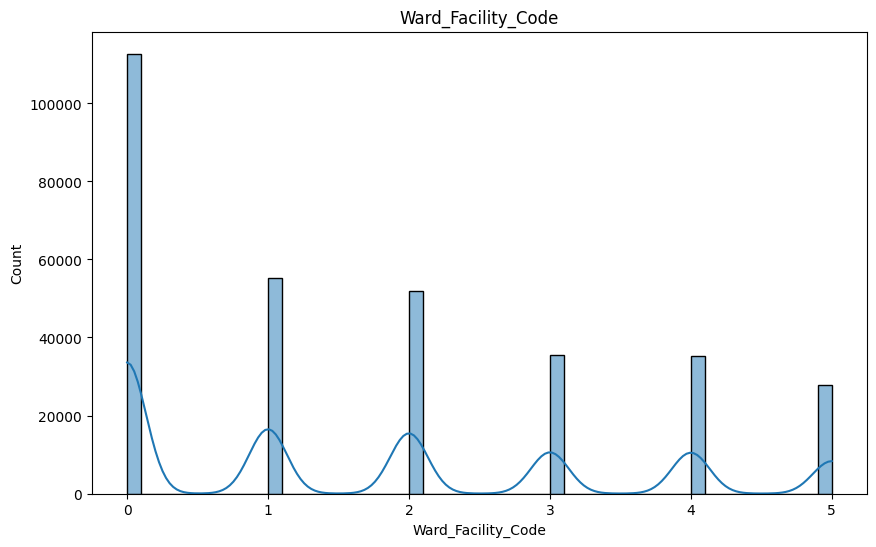

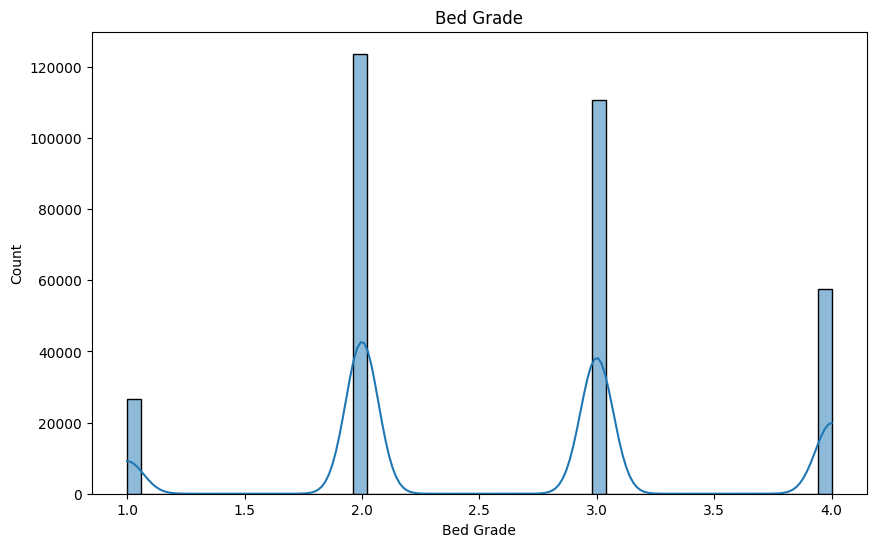

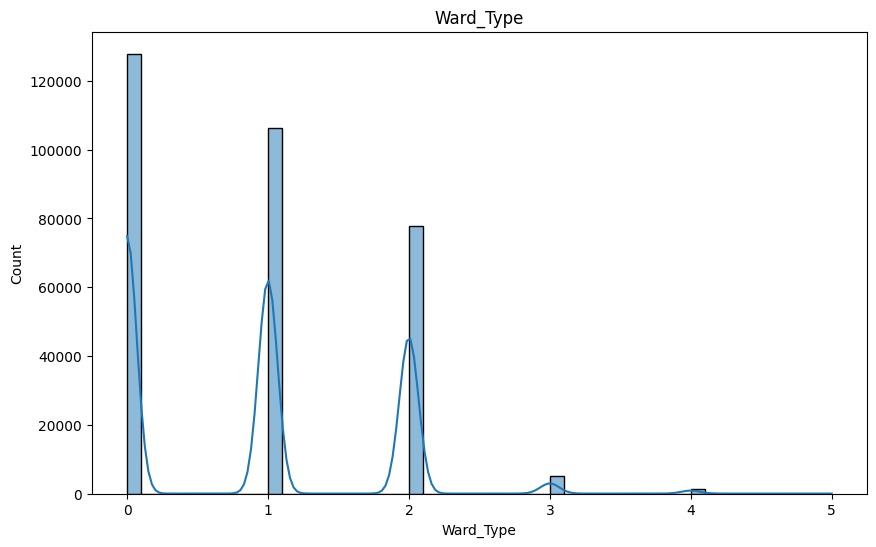

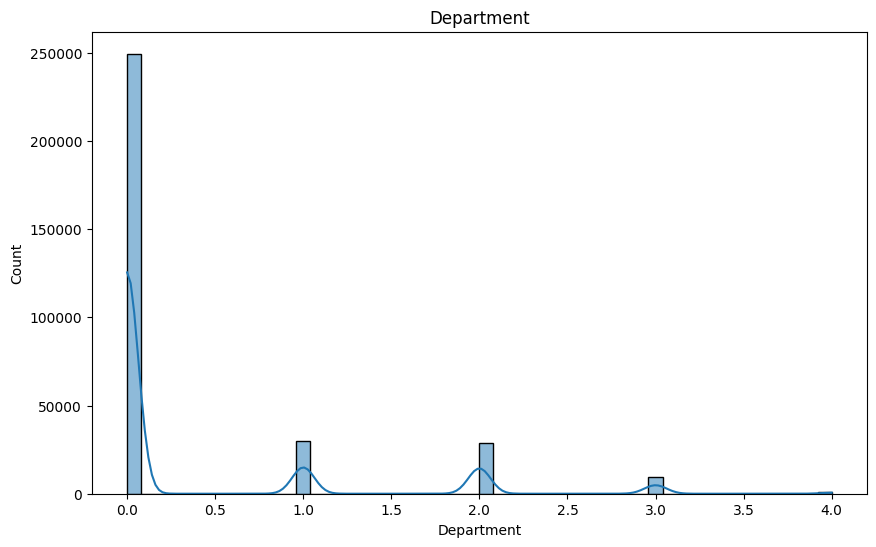

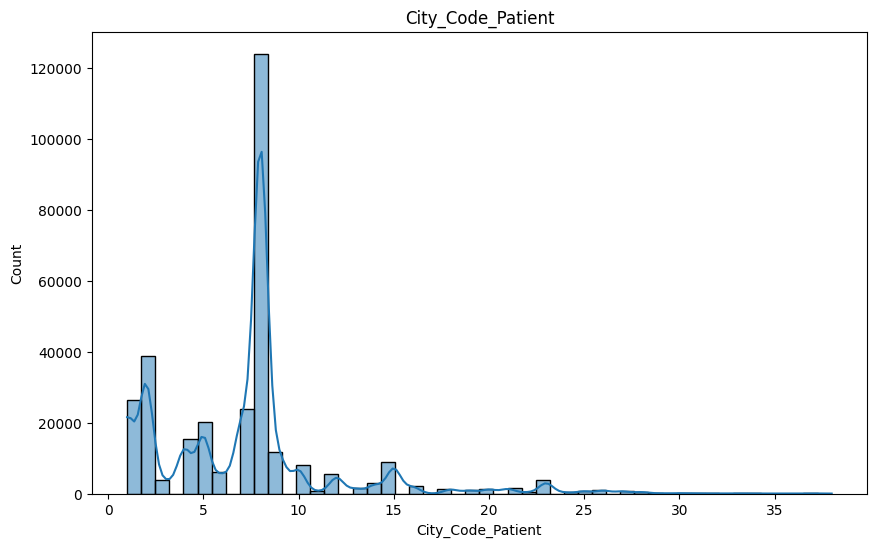

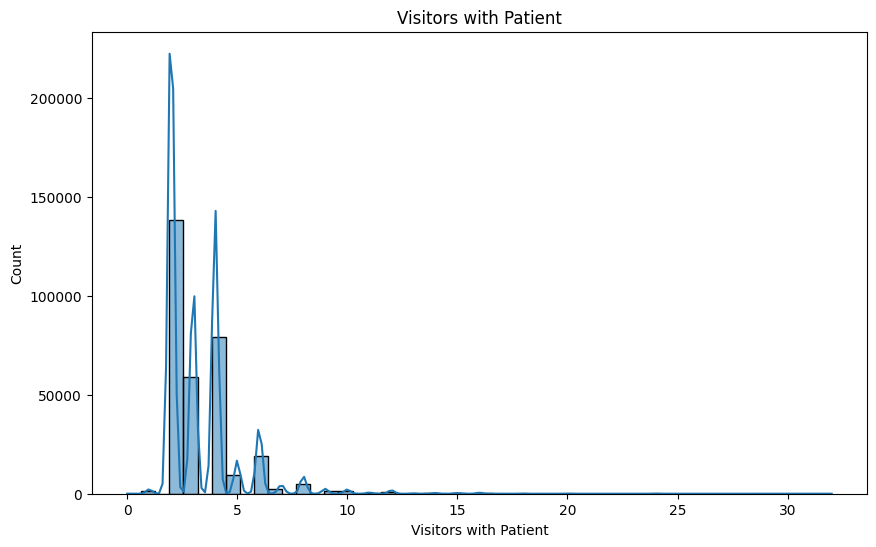

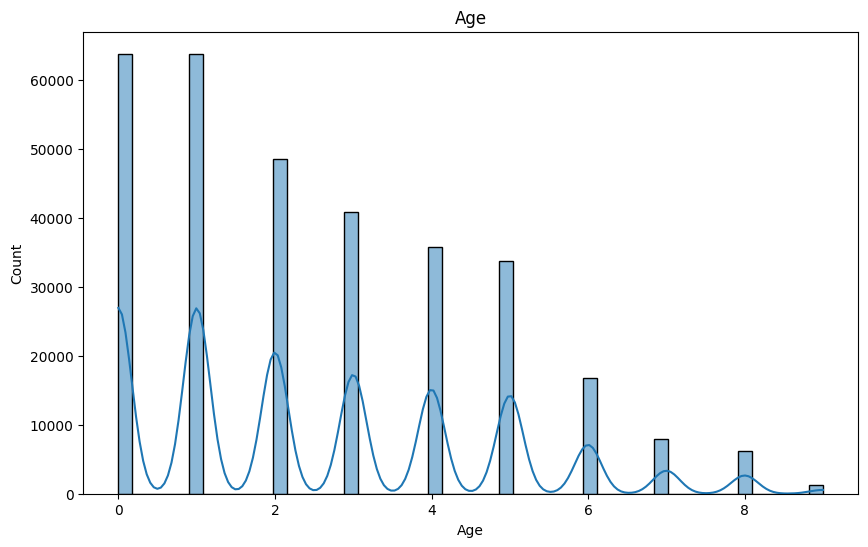

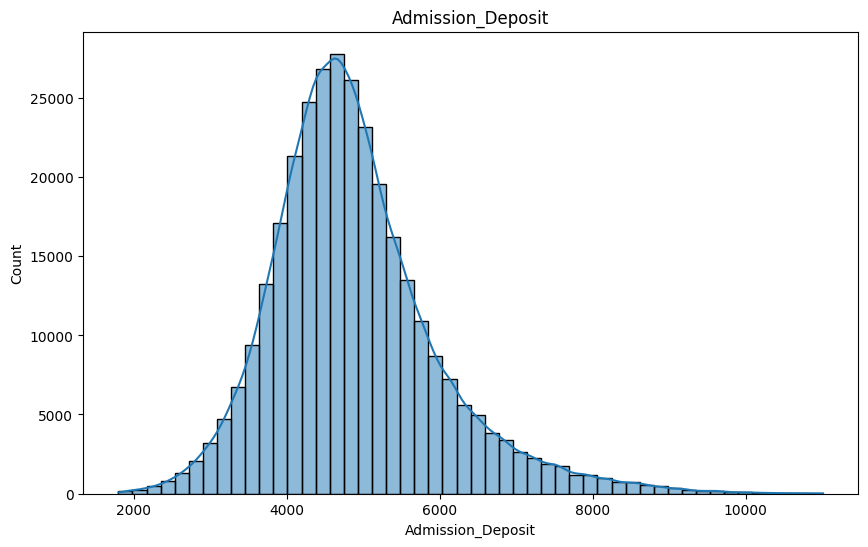

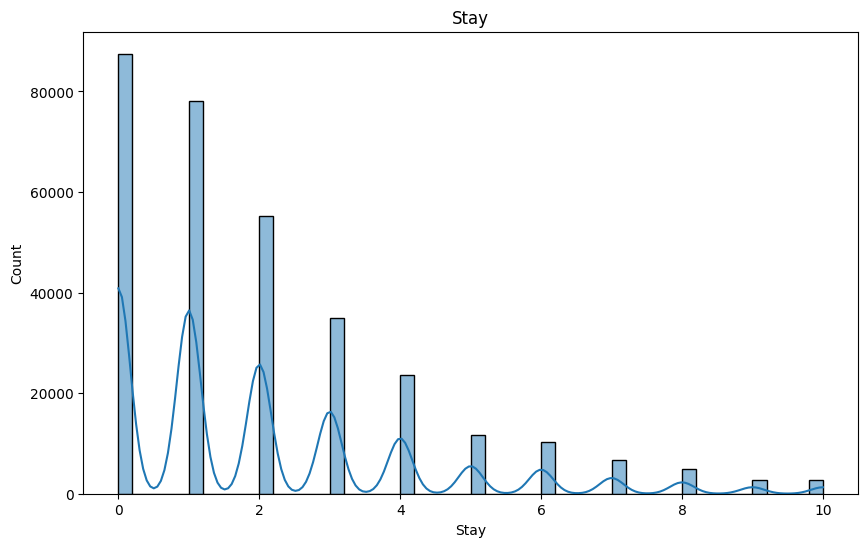

In [17]:
Features = ['Hospital_code', 'City_Code_Hospital', 'Hospital_type_code', 'Available Extra Rooms in Hospital', 'Ward_Facility_Code', 'Bed Grade', 'Ward_Type', 'Department', 'City_Code_Patient', 'Visitors with Patient', 'Age', 'Admission_Deposit', 'Stay']
for data in Features:
    plt.figure(figsize=(10, 6))
    plt.title(data)
    sns.histplot(health_data_pd[data], bins=50, kde=True)
    plt.show()

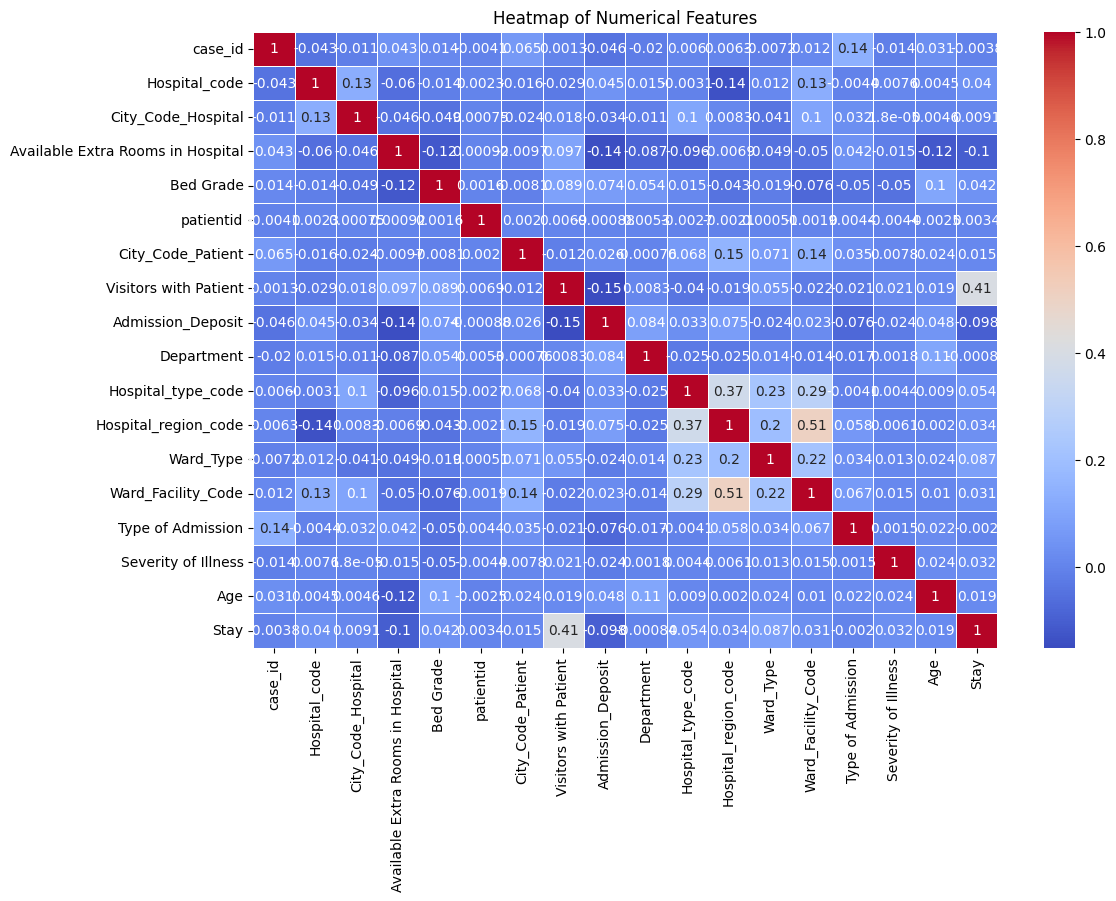

In [18]:
# Create a heatmap for numerical features
plt.figure(figsize=(12, 8))
correlation_matrix = health_data_pd.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Heatmap of Numerical Features')
plt.show()

In [19]:
# Stop Spark session
spark.stop()

0:	learn: 2.2436631	total: 2.48s	remaining: 41m 15s
100:	learn: 1.4264253	total: 4m 49s	remaining: 42m 55s
200:	learn: 1.3820777	total: 9m 32s	remaining: 37m 54s
300:	learn: 1.3609046	total: 14m 17s	remaining: 33m 10s
400:	learn: 1.3453329	total: 19m	remaining: 28m 23s
500:	learn: 1.3308832	total: 23m 48s	remaining: 23m 42s
600:	learn: 1.3198472	total: 28m 35s	remaining: 18m 58s
700:	learn: 1.3109901	total: 33m 21s	remaining: 14m 13s
800:	learn: 1.3034640	total: 38m 12s	remaining: 9m 29s
900:	learn: 1.2971405	total: 43m	remaining: 4m 43s
999:	learn: 1.2910763	total: 47m 43s	remaining: 0us
Training Accuracy: 0.5237807897660831


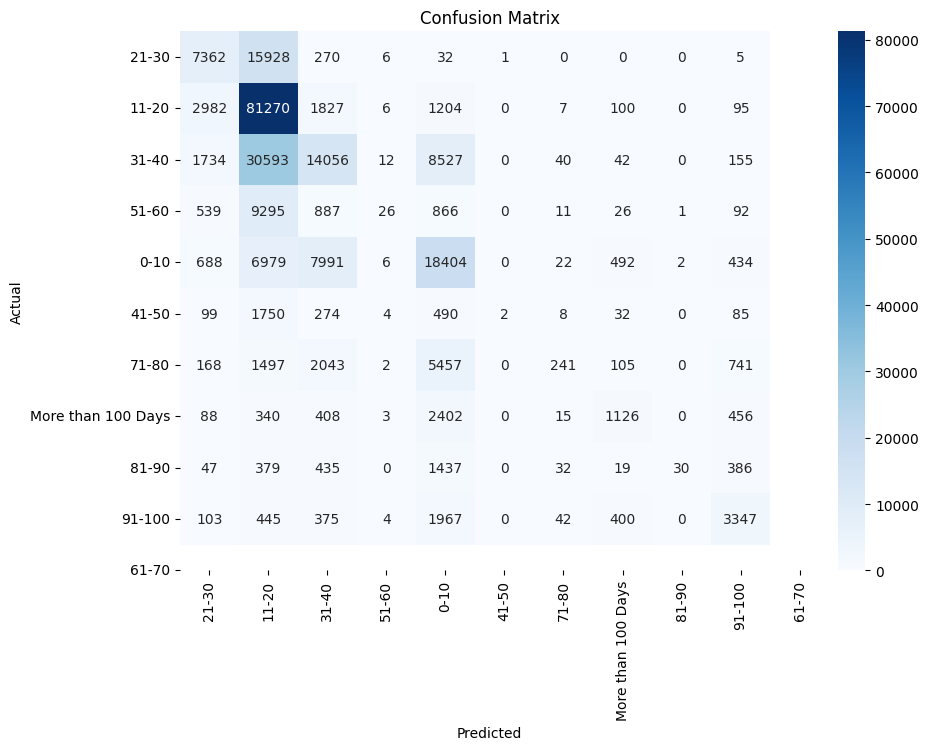

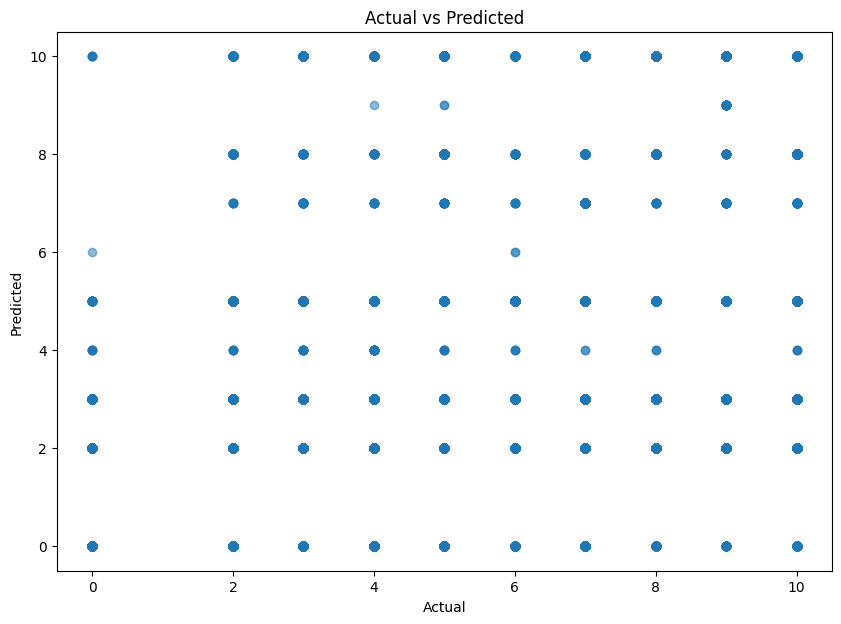

Actual: 0.0, Predicted: [2.]
Actual: 4.0, Predicted: [2.]
Actual: 3.0, Predicted: [2.]
Actual: 4.0, Predicted: [2.]
Actual: 4.0, Predicted: [2.]
Actual: 0.0, Predicted: [0.]
Actual: 4.0, Predicted: [2.]
Actual: 5.0, Predicted: [2.]
Actual: 3.0, Predicted: [2.]
Actual: 2.0, Predicted: [2.]


In [20]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Initialize Spark session
spark = SparkSession.builder.appName("HospitalStayPrediction").getOrCreate()

# Load data
sparktrain = spark.read.csv('/content/drive/MyDrive/big data/Final dataset/train_data.csv', header=True, inferSchema=True)
sparkTest = spark.read.csv('/content/drive/MyDrive/big data/Final dataset/test_data.csv', header=True, inferSchema=True)
warnings.filterwarnings("ignore")

# Convert Spark DataFrame to Pandas DataFrame
train = sparktrain.toPandas()
test = sparkTest.toPandas()

# Add column to differentiate between train and test sets
train['train_or_test'] = 'train'
test['train_or_test'] = 'test'
df = pd.concat([train, test])

# Define mappings for categorical features
hospital_type_map = {'a': 0, 'b': 1, 'c': 2, 'e': 3, 'd': 4, 'f': 5, 'g': 6}
hospital_region_map = {'X': 0, 'Y': 1, 'Z': 2}
dep_map = {'gynecology': 0, 'anesthesia': 1, 'radiotherapy': 2, 'TB & Chest disease': 3, 'surgery': 4}
ward_type_map = {'R': 0, 'Q': 1, 'S': 2, 'P': 3, 'T': 4, 'U': 5}
ward_fac_map = {'F': 0, 'E': 1, 'D': 2, 'C': 3, 'B': 4, 'A': 5}
admiss_map = {'Trauma': 0, 'Emergency': 1, 'Urgent': 2}
stay_map = {'21-30': 2, '11-20': 1, '31-40': 3, '51-60': 5, '0-10': 0, '41-50': 4, '71-80': 7, 'More than 100 Days': 10, '81-90': 8, '91-100': 9, '61-70': 6}
severity_map = {'Minor': 1, 'Moderate ': 2, 'Extreme': 3}
age_map = {'0-10': 5, '11-20': 15, '21-30': 25, '31-40': 35, '41-50': 45, '51-60': 55, '61-70': 65, '71-80': 75, '81-90': 85, '91-100': 95}

# Apply mappings
df['Hospital_type_code'] = df['Hospital_type_code'].map(hospital_type_map)
df['Hospital_region_code'] = df['Hospital_region_code'].map(hospital_region_map)
df['Department'] = df['Department'].map(dep_map)
df['Ward_Type'] = df['Ward_Type'].map(ward_type_map)
df['Ward_Facility_Code'] = df['Ward_Facility_Code'].map(ward_fac_map)
df['Type of Admission'] = df['Type of Admission'].map(admiss_map)
df['Stay'] = df['Stay'].map(stay_map)
df['Severity of Illness'] = df['Severity of Illness'].map(severity_map)
df['Age'] = df['Age'].map(age_map)

# Feature engineering
def generate_features(df):
    df['mean_Admission_Deposit_per_illness'] = df.groupby('Severity of Illness')['Admission_Deposit'].transform('mean')
    df['mean_Admission_Deposit_per_admission'] = df.groupby('Type of Admission')['Admission_Deposit'].transform('mean')
    df['mean_Admission_Deposit_per_bed'] = df.groupby('Bed Grade')['Admission_Deposit'].transform('mean')
    df['mean_Admission_Deposit_per_department'] = df.groupby('Department')['Admission_Deposit'].transform('mean')
    df['mean_Admission_Deposit_per_hosp'] = df.groupby('Hospital_code')['Admission_Deposit'].transform('mean')
    df['sum_Admission_Deposit_per_illness'] = df.groupby('Severity of Illness')['Admission_Deposit'].transform('sum')
    df['sum_Admission_Deposit_per_admission'] = df.groupby('Type of Admission')['Admission_Deposit'].transform('sum')
    df['sum_Admission_Deposit_per_bed'] = df.groupby('Bed Grade')['Admission_Deposit'].transform('sum')
    df['sum_Admission_Deposit_per_department'] = df.groupby('Department')['Admission_Deposit'].transform('sum')
    df['sum_Admission_Deposit_per_hosp'] = df.groupby('Hospital_code')['Admission_Deposit'].transform('sum')
    df['max_Admission_Deposit_per_illness'] = df.groupby('Severity of Illness')['Admission_Deposit'].transform('max')
    df['max_Admission_Deposit_per_admission'] = df.groupby('Type of Admission')['Admission_Deposit'].transform('max')
    df['max_Admission_Deposit_per_bed'] = df.groupby('Bed Grade')['Admission_Deposit'].transform('max')
    df['max_Admission_Deposit_per_department'] = df.groupby('Department')['Admission_Deposit'].transform('max')
    df['max_Admission_Deposit_per_hosp'] = df.groupby('Hospital_code')['Admission_Deposit'].transform('max')
    df['min_Admission_Deposit_per_illness'] = df.groupby('Severity of Illness')['Admission_Deposit'].transform('min')
    df['min_Admission_Deposit_per_admission'] = df.groupby('Type of Admission')['Admission_Deposit'].transform('min')
    df['min_Admission_Deposit_per_bed'] = df.groupby('Bed Grade')['Admission_Deposit'].transform('min')
    df['min_Admission_Deposit_per_department'] = df.groupby('Department')['Admission_Deposit'].transform('min')
    df['min_Admission_Deposit_per_hosp'] = df.groupby('Hospital_code')['Admission_Deposit'].transform('min')
    df['mean_Admission_Deposit_per_patient_hosp'] = df.groupby(['patientid', 'Hospital_code'])['Admission_Deposit'].transform('mean')
    df['sum_Admission_Deposit_per_patient_hosp'] = df.groupby(['patientid', 'Hospital_code'])['Admission_Deposit'].transform('sum')
    df['max_Admission_Deposit_per_patient_hosp'] = df.groupby(['patientid', 'Hospital_code'])['Admission_Deposit'].transform('max')
    df['min_Admission_Deposit_per_patient_hosp'] = df.groupby(['patientid', 'Hospital_code'])['Admission_Deposit'].transform('min')
    df['illness_count'] = df.groupby('Hospital_code')['Severity of Illness'].transform('count')
    df['bed_count'] = df.groupby('Hospital_code')['Bed Grade'].transform('count')
    df['room_count'] = df.groupby('Hospital_code')['Available Extra Rooms in Hospital'].transform('count')
    df['Department_count'] = df.groupby('Hospital_code')['Department'].transform('count')
    df['ward_count'] = df.groupby('Hospital_code')['Ward_Type'].transform('count')
    df['TOA_count'] = df.groupby('Hospital_code')['Type of Admission'].transform('count')
    df['meanVisitors_with_Patient_per_patient'] = df.groupby('patientid')['Visitors with Patient'].transform('mean')
    df['sumVisitors_with_Patient_per_patient'] = df.groupby('patientid')['Visitors with Patient'].transform('sum')
    df['maxVisitors_with_Patient_per_patient'] = df.groupby('patientid')['Visitors with Patient'].transform('max')
    df['minVisitors_with_Patient_per_patient'] = df.groupby('patientid')['Visitors with Patient'].transform('min')
    df['unique_hospital_visited'] = df.groupby('patientid')['Hospital_code'].transform('nunique')
    df['unique_hospitaltype_visited'] = df.groupby('patientid')['Hospital_type_code'].transform('nunique')
    df['count_visited_same_hospital'] = df.groupby(['patientid', 'Hospital_code'])['Hospital_code'].transform('count')
    df['mean_Admission_Deposit_per_patient'] = df.groupby('patientid')['Admission_Deposit'].transform('mean')
    df['sum_Admission_Deposit_per_patient'] = df.groupby('patientid')['Admission_Deposit'].transform('sum')
    df['max_Admission_Deposit_per_patient'] = df.groupby('patientid')['Admission_Deposit'].transform('max')
    df['min_Admission_Deposit_per_patient'] = df.groupby('patientid')['Admission_Deposit'].transform('min')
    df['unique_city'] = df.groupby('patientid')['City_Code_Hospital'].transform('nunique')
    df['unique_illness_type'] = df.groupby('patientid')['Severity of Illness'].transform('nunique')
    df['unique_admission_type'] = df.groupby('patientid')['Type of Admission'].transform('nunique')
    df['mean_Admission_Deposit_per_patient_in_same_hospital'] = df.groupby(['patientid', 'Hospital_code'])['Admission_Deposit'].transform('mean')
    df['total_no_of_patients_in_hospital'] = df.groupby('Hospital_code')['patientid'].transform('count')
    df['total_no_of_patients_in_hospital_from_same_city'] = df.groupby(['Hospital_code', 'City_Code_Patient'])['patientid'].transform('count')
    df['total_no_of_patients_in_patientcity'] = df.groupby('City_Code_Patient')['patientid'].transform('count')
    df['total_no_of_patients_in_hospitalcity'] = df.groupby('City_Code_Hospital')['patientid'].transform('count')
    df['total_no_of_uniqpat_hosp_wise'] = df.groupby('Hospital_code')['patientid'].transform('nunique')
    df['total_no_of_uniqpat_city_wise'] = df.groupby('City_Code_Hospital')['patientid'].transform('nunique')
    df['patient_no_of_illness'] = df.groupby('patientid')['Severity of Illness'].transform('count')
    df['patient_no_of_dept'] = df.groupby('patientid')['Department'].transform('nunique')
    df['patient_no_of_admission_type'] = df.groupby('patientid')['Type of Admission'].transform('nunique')
    df['meanVisitors_with_Patient_per_patient_hosp'] = df.groupby(['patientid', 'Hospital_code'])['Visitors with Patient'].transform('mean')
    df['sumVisitors_with_Patient_per_patient_hosp'] = df.groupby(['patientid', 'Hospital_code'])['Visitors with Patient'].transform('sum')
    df['maxVisitors_with_Patient_per_patient_hosp'] = df.groupby(['patientid', 'Hospital_code'])['Visitors with Patient'].transform('max')
    df['minVisitors_with_Patient_per_patient_hosp'] = df.groupby(['patientid', 'Hospital_code'])['Visitors with Patient'].transform('min')
    return df

df = generate_features(df)

# Separate train and test data
train = df[df['train_or_test'] == 'train'].drop(columns=['train_or_test'])
test = df[df['train_or_test'] == 'test'].drop(columns=['train_or_test'])

# Handle missing values in the target
train = train.dropna(subset=['Stay'])

# Define features and target
X = train.drop(columns=['Stay', 'case_id'])
y = train['Stay']
X_test = test.drop(columns=['Stay', 'case_id'])

# Define the CatBoost model
clf = CatBoostClassifier(iterations=1000, learning_rate=0.03, depth=6, loss_function='MultiClass', verbose=100)

# Train the model
clf.fit(X, y)

# Predict on the training set
train_pred = clf.predict(X)
train_prob = clf.predict_proba(X)

# Calculate accuracy
train_accuracy = accuracy_score(y, train_pred)
print(f"Training Accuracy: {train_accuracy}")

# Predict on the test set
test_prob = clf.predict_proba(X_test)
final_predictions = np.argmax(test_prob, axis=1)

# Create confusion matrix and heatmap
cm = confusion_matrix(y, train_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(stay_map.keys()), yticklabels=list(stay_map.keys()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot actual vs predicted
plt.figure(figsize=(10, 7))
plt.scatter(y, train_pred, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

# Print some actual vs predicted examples
for actual, predicted in zip(y[:10], train_pred[:10]):
    print(f"Actual: {actual}, Predicted: {predicted}")
